# 0.6 McNulty — Merging Building Permit Data

In [1]:
import mcnultymod
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
from geopy.distance import vincenty

import pickle

from datetime import datetime, timedelta, date

In [2]:
auctions = pd.read_pickle('../data/auctionsclosed.pkl')

In [3]:
auctions.sort_values(by='closingdate').head()

,address,parcelid,price,closingdate,salestatus,buyerstatus,purchasertype,program,councildistrict,neighborhood,latitude,longitude,location
715,2499 Longfellow,10002638.,29100.0,2014-06-12,Closed,Selected,Homebuyer,Auction,5,Boston Edison,42.375830,-83.108916,"location\n(42.37583, -83.108916)"
633,5811 Grayton,21074175.,10500.0,2014-07-10,Closed,Selected,Homebuyer,Auction,4,East English Village,42.411569,-82.936629,"location\n(42.411569, -82.936629)"
595,16905 Chandler Park Dr,21009371-2,8200.0,2014-07-23,Closed,Selected,Homebuyer,Auction,4,East English Village,42.410584,-82.935297,"location\n(42.410584, -82.935297)"
181,6008 Auburn,22092071.,4600.0,2014-07-30,Closed,Selected,Homebuyer,Auction,7,Warrendale,42.332545,-83.232177,"location\n(42.332545, -83.232177)"
614,4690 Devonshire,21070427.,7000.0,2014-08-06,Closed,Selected,Investor,Auction,4,Morningside,42.399628,-82.940238,"location\n(42.399628, -82.940238)"


In [4]:
cnx = mcnultymod.connect_to_sql('52.14.0.197')

In [5]:
permits = pd.read_sql_query('''
    SELECT auctionsclosed.parcelid AS parcelid,
       dateissued,
       estimatedcost,
       parcelsize,
       bldpermittype,
       bldtypeuse,
       owner_city,
       owner_state
    FROM auctionsclosed
    JOIN buildingpermits
    ON auctionsclosed.parcelid = buildingpermits.parcelid
    WHERE dateissued > '2014-06-01'
    ; 
    ''', cnx)

In [6]:
permits.shape

(428, 8)

In [7]:
permits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 8 columns):
parcelid         428 non-null object
dateissued       428 non-null object
estimatedcost    416 non-null object
parcelsize       428 non-null float64
bldpermittype    426 non-null object
bldtypeuse       427 non-null object
owner_city       428 non-null object
owner_state      428 non-null object
dtypes: float64(1), object(7)
memory usage: 26.8+ KB


In [8]:
permits.estimatedcost = permits.loc[:, 'estimatedcost'].apply(lambda c: mcnultymod.convert_cash(c))

In [9]:
permits.bldtypeuse.value_counts()

One Family Dwelling    376
Two Family Dwelling     37
Multiple Dwelling       11
Private Garage           2
Commercial Building      1
Name: bldtypeuse, dtype: int64

In [10]:
permits.owner_city.value_counts()

DETROIT              341
SOUTHFIELD            11
DEARBORN               9
WARREN                 4
TAYLOR                 3
WESTLAND               2
LOS ANGELES            2
SHELBY TWP             2
SAN DIEGO              2
YPSILANTI              2
LIVONIA                2
SAN FRANCISCO          2
EASTPOINTE             2
DEARBORN HEIGHTS       2
ANN ARBOR              2
MIAMI                  2
LEWISVILLE             1
MT. PLEASANT           1
HAMTRAMCK              1
ROCHESTER HILLS        1
DEARBORN HGHS          1
GILBERT                1
PLYMOUTH               1
TROY                   1
W. BLOOMFIELD          1
OAK PARK               1
SANTA ANA              1
STERLING HEIGHTS       1
SAN FRANSICO           1
CLAWSON                1
CANTON                 1
SAN JOSE               1
DEARBORN HGTS          1
SUMMERVILLE            1
VAN BUREN TWP          1
MIAMISBURG             1
HIGHLAND PARK          1
COMMERCE               1
MADISON HEIGHTS        1
BROWNSTOWN             1


In [11]:
permits.bldpermittype.value_counts()

Alterations            300
Repairs                 73
Alterations Revised     20
Dismantle               11
Change of Use            6
Repair Fire              5
Change of Occupancy      4
New                      3
Additions                3
Reduce Occupancy         1
Name: bldpermittype, dtype: int64

Bin **owner_city** into Detroit (1) / not-Detroit (0)

In [12]:
permits['oc_bin'] = 0
permits.oc_bin[permits.owner_city == 'DETROIT'] = 1

/Users/dluther/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Bin **owner_state** into MI (1) / not-MI (0)

In [13]:
permits['os_bin'] = 0
permits.os_bin[permits.owner_state == 'MI'] = 1

/Users/dluther/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [14]:
permits.head()

,parcelid,dateissued,estimatedcost,parcelsize,bldpermittype,bldtypeuse,owner_city,owner_state,oc_bin,os_bin
0,08003105.,2016-05-05,60000.0,8964.0,Alterations,One Family Dwelling,DETROIT,MI,1,1
1,10001768.,2017-02-01,6742.0,5140.0,Alterations,Multiple Dwelling,LEWISVILLE,TX,0,0
2,03002686.,2017-02-07,1000.0,10716.0,Alterations,One Family Dwelling,DETROIT,MI,1,1
3,21056239.,2016-05-18,40000.0,5619.0,Alterations Revised,One Family Dwelling,DEARBORN,MI,0,1
4,01002440.,2017-02-08,23000.0,4400.0,Alterations,One Family Dwelling,DETROIT,MI,1,1


''

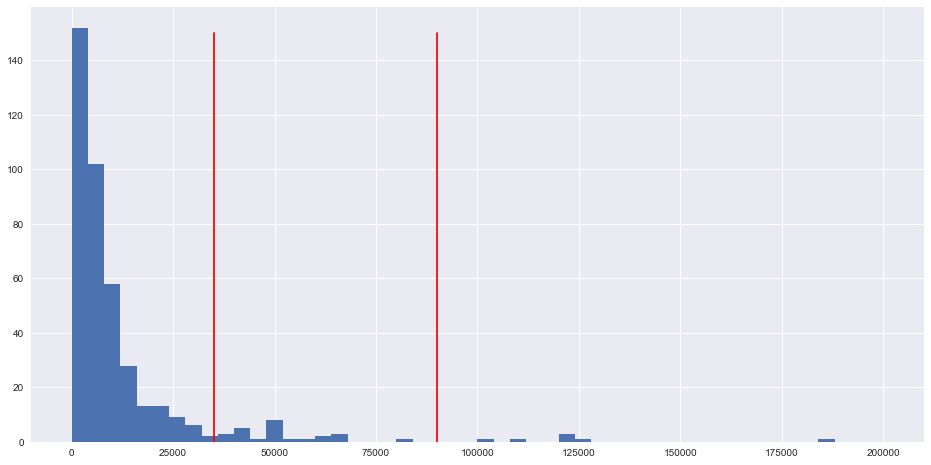

In [15]:
x = permits.estimatedcost.dropna()

x_line1 = [35000] * 7
y_line1 = [i*25 for i in range(7)]
x_line2 = [90000] * 7
y_line2 = [i*25 for i in range(7)]

plt.figure(figsize=(16,8))
plt.hist(x, bins=50, range=[0,200000])
plt.plot(x_line1, y_line1, 'r-')
plt.plot(x_line2, y_line2, 'r-')
# plt.xticks([n*5 for n in range(21)])
# plt.xlabel("Neighborhood Counts", fontsize=12)
# plt.ylabel("Frequency", fontsize=12)
# plt.title("Histogram of Neighborhood Occurrences", fontsize=18)
;

Possible point for binning if this variable is used

''

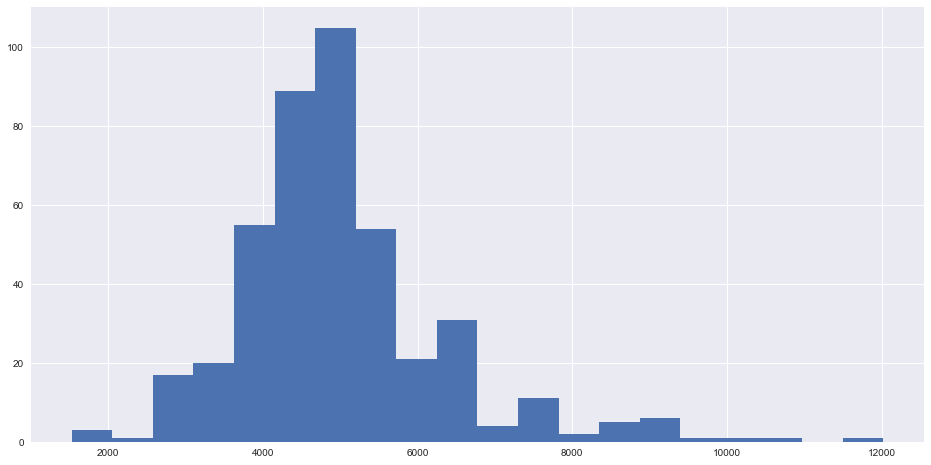

In [16]:
x = permits.parcelsize

# x_line1 = [35000] * 7
# y_line1 = [i*25 for i in range(7)]
# x_line2 = [90000] * 7
# y_line2 = [i*25 for i in range(7)]

plt.figure(figsize=(16,8))
plt.hist(x, bins=20)
# plt.plot(x_line1, y_line1, 'r-')
# plt.plot(x_line2, y_line2, 'r-')
# plt.xticks([n*5 for n in range(21)])
# plt.xlabel("Neighborhood Counts", fontsize=12)
# plt.ylabel("Frequency", fontsize=12)
# plt.title("Histogram of Neighborhood Occurrences", fontsize=18)
;

In [17]:
permits.groupby(['parcelid', 'dateissued']).parcelsize.count().sort_values(ascending=False).head()

parcelid   dateissued
06002469.  2015-08-05    2
22091697.  2016-09-21    2
22121208.  2017-07-26    1
16033834.  2015-11-12    1
16030339.  2014-10-01    1
Name: parcelsize, dtype: int64

In [18]:
permits.to_pickle('../data/permits_sub.pkl')

### Merging Select Permit Info with Auctions

In [19]:
auctions.head()

,address,parcelid,price,closingdate,salestatus,buyerstatus,purchasertype,program,councildistrict,neighborhood,latitude,longitude,location
243,6784 Asbury Park,22060958-9,7700.0,2014-12-19,Closed,Selected,Homebuyer,Auction,7,Warren Ave Community,42.341163,-83.205641,"location\n(42.341163, -83.205641)"
819,14345 Grandville,22088763.,11400.0,2015-04-23,Closed,Selected,Investor,Auction,1,Westwood Park,42.391877,-83.231375,"location\n(42.391877, -83.231375)"
1068,6754 Iowa,15004080-1,1000.0,2017-01-05,Closed,Selected,Homebuyer,Auction,3,Grant,42.424756,-83.032456,"location\n(42.424756, -83.032456)"
674,2224 W Boston Blvd,10002831.,62800.0,2015-06-17,Closed,Selected,Investor,Auction,5,Boston Edison,42.380017,-83.106803,"location\n(42.380017, -83.106803)"
1339,17650 Beland,17015265.,1100.0,2017-04-28,Closed,Selected,Homebuyer,Auction,3,Mount Olivet,42.424499,-83.008787,"location\n(42.424499, -83.008787)"


In [20]:
permits.head()

,parcelid,dateissued,estimatedcost,parcelsize,bldpermittype,bldtypeuse,owner_city,owner_state,oc_bin,os_bin
0,08003105.,2016-05-05,60000.0,8964.0,Alterations,One Family Dwelling,DETROIT,MI,1,1
1,10001768.,2017-02-01,6742.0,5140.0,Alterations,Multiple Dwelling,LEWISVILLE,TX,0,0
2,03002686.,2017-02-07,1000.0,10716.0,Alterations,One Family Dwelling,DETROIT,MI,1,1
3,21056239.,2016-05-18,40000.0,5619.0,Alterations Revised,One Family Dwelling,DEARBORN,MI,0,1
4,01002440.,2017-02-08,23000.0,4400.0,Alterations,One Family Dwelling,DETROIT,MI,1,1


In [21]:
permits_temp = pd.merge(auctions.filter(['parcelid', 'closingdate']), permits, how='inner', on='parcelid')

I will assume that if a permit was issued more than 30 days before the auction closing date, it was unrelated.

In [22]:
permits_temp.shape

(327, 11)

In [23]:
permits_temp[
    # (permits_temp.closingdate > permits_temp.dateissued) & 
    (permits_temp.closingdate - permits_temp.dateissued > timedelta(days=30))
            ]

,parcelid,closingdate,dateissued,estimatedcost,parcelsize,bldpermittype,bldtypeuse,owner_city,owner_state,oc_bin,os_bin
11,10002780.,2015-07-16,2015-03-30,2500.0,8364.0,Alterations,One Family Dwelling,DETROIT,MI,1,1
22,22105421.,2017-04-14,2015-10-12,1299.0,4704.0,Alterations,One Family Dwelling,SOUTHFIELD,MI,0,1
34,08002810.,2017-02-27,2016-02-16,5000.0,5358.0,Alterations,One Family Dwelling,DETROIT,MI,1,1
41,16035637.,2015-06-25,2015-05-05,NaN,4008.0,Dismantle,One Family Dwelling,DETROIT,MI,1,1
54,16036039.,2015-07-17,2015-05-04,NaN,4008.0,Dismantle,Commercial Building,DETROIT,MI,1,1
55,16036039.,2015-07-17,2015-05-05,NaN,4008.0,Dismantle,One Family Dwelling,DETROIT,MI,1,1
73,21054492.,2017-03-31,2016-09-22,9500.0,5619.0,Alterations,Multiple Dwelling,DETROIT,MI,1,1
93,22055535.,2017-06-08,2016-02-08,4500.0,6273.0,Alterations,Two Family Dwelling,ROYAL OAK,MI,0,1
119,22050836.003L,2015-10-27,2015-02-16,1300.0,3659.0,Alterations,One Family Dwelling,DETROIT,MI,1,1
156,16036036.,2015-09-25,2015-05-13,NaN,4008.0,Dismantle,One Family Dwelling,DETROIT,MI,1,1


In [24]:
permits_temp = (permits_temp[
    permits_temp.closingdate - permits_temp.dateissued < timedelta(days=30)
]
)

In [25]:
permits_temp.shape

(314, 11)

In [29]:
permit_counts = permits_temp.parcelid.value_counts()

permit_counts.name = 'num_permits'

permit_counts = pd.DataFrame(permit_counts).reset_index()
permit_counts.rename(columns={'index': 'parcelid'}, inplace=True)
permit_counts.head()

,parcelid,num_permits
0,06002469.,3
1,01002440.,3
2,22081834.,3
3,06002274.,3
4,16034236.,3


Before merging any more detailed permit information with the auctions dataframe, I'll just add a column of permit counts (0 for none filed).

In [30]:
auctions = pd.merge(auctions, permit_counts, how='left', on='parcelid')

auctions.fillna(0, inplace=True)

In [31]:
auctions.num_permits.value_counts()

0.0    777
1.0    226
2.0     32
3.0      8
Name: num_permits, dtype: int64

''

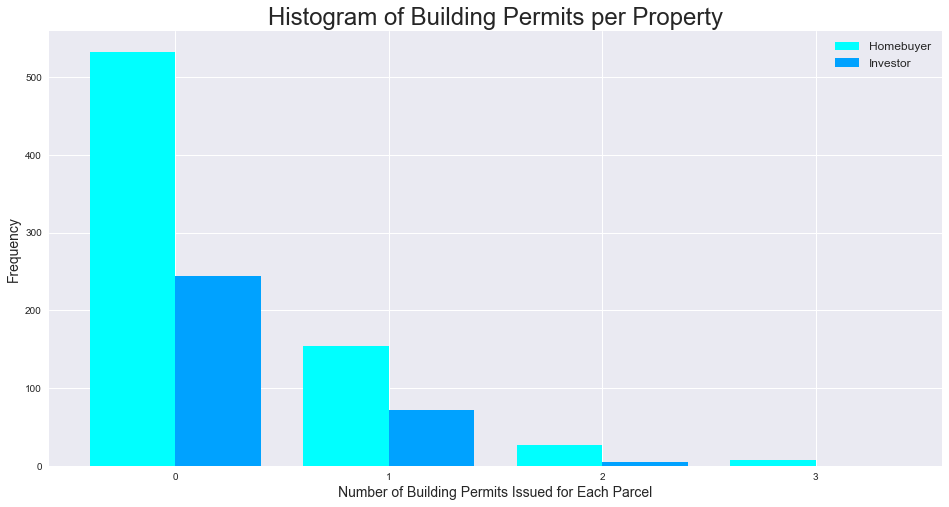

In [81]:
x = []

for buyer in ['Homebuyer', 'Investor']:
    x_sub = np.array(auctions.num_permits[auctions.purchasertype == buyer])
    x.append(x_sub)

plt.figure(figsize=(16,8))
plt.hist(x, bins=4, color=['cyan', '#00A2FF'], label=['Homebuyer', 'Investor'], range=[-0.5,3.5])
plt.xticks([n for n in range(4)])
plt.xlabel("Number of Building Permits Issued for Each Parcel", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.title("Histogram of Building Permits per Property", fontsize=24)
plt.savefig('../img/hist_permits.png', dpi=200, bbox_inches = 'tight')
;

### Adding a Year Column

In [33]:
auctions['year'] = auctions.closingdate.apply(lambda d: d.year)

In [34]:
auctions['ptype_num'] = 0
auctions.ptype_num[auctions.purchasertype == 'Investor'] = 1

/Users/dluther/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [35]:
auctions.sample(10)

,address,parcelid,price,closingdate,salestatus,buyerstatus,purchasertype,program,councildistrict,neighborhood,latitude,longitude,location,num_permits,year,ptype_num
992,6224 Artesian,22084142.,1000.0,2016-02-24,Closed,Selected,Homebuyer,Auction,7,Warrendale,42.334971,-83.224930,"location\n(42.334971, -83.22493)",0.0,2016,0
494,11715 Stahelin,22083785.,3300.0,2015-12-15,Closed,Selected,Homebuyer,Auction,7,Southfield Plymouth,42.373812,-83.225757,"location\n(42.373812, -83.225757)",0.0,2015,0
539,4207 Grayton,21074280.,26050.0,2015-06-18,Closed,Selected,Homebuyer,Auction,4,East English Village,42.399497,-82.928668,"location\n(42.399497, -82.928668)",0.0,2015,0
208,18247 Lahser,22113676.,1000.0,2016-06-13,Closed,Selected,Homebuyer,Auction,1,Old Redford,42.422651,-83.258500,"location\n(42.422651, -83.2585)",0.0,2016,0
1020,2234 Edison,10002610.,3700.0,2015-06-12,Closed,Selected,Investor,Auction,5,Boston Edison,42.376846,-83.104909,"location\n(42.376846, -83.104909)",1.0,2015,1
771,8505 Prest,22049423.,8500.0,2016-05-03,Closed,Selected,Homebuyer,Auction,7,Fiskhorn,42.355911,-83.196062,"location\n(42.355911, -83.196062)",0.0,2016,0
1011,16111 Biltmore,22064475.,1000.0,2016-09-09,Closed,Selected,Homebuyer,Auction,1,Crary/St Marys,42.408745,-83.210989,"location\n(42.408745, -83.210989)",0.0,2016,0
649,6015 Cadieux,21075246.001,4900.0,2014-08-15,Closed,Selected,Homebuyer,Auction,4,Cornerstone Village,42.414307,-82.934862,"location\n(42.414307, -82.934862)",0.0,2014,0
1,14345 Grandville,22088763.,11400.0,2015-04-23,Closed,Selected,Investor,Auction,1,Westwood Park,42.391877,-83.231375,"location\n(42.391877, -83.231375)",0.0,2015,1
663,5177 Harold,13005690.,17600.0,2015-01-14,Closed,Selected,Homebuyer,Auction,3,Buffalo Charles,42.406615,-83.047521,"location\n(42.406615, -83.047521)",0.0,2015,0


### Binning Neighborhoods by Investor Ratio

In [36]:
n_counts = (auctions
            .neighborhood
            .value_counts()
            .reset_index()
            .rename(columns={'index': 'neighborhood', 'neighborhood': 'n_count'})
           )

n_counts = mcnultymod.nhood_investor_ratios(auctions, n_counts)

In [37]:
n_counts.describe()

,n_count,inv_ratio
count,110.000000,110.000000
mean,9.481818,0.322143
std,14.063899,0.303515
min,1.000000,0.000000
25%,2.000000,0.000000
50%,4.000000,0.297059
75%,12.000000,0.454861
max,99.000000,1.000000


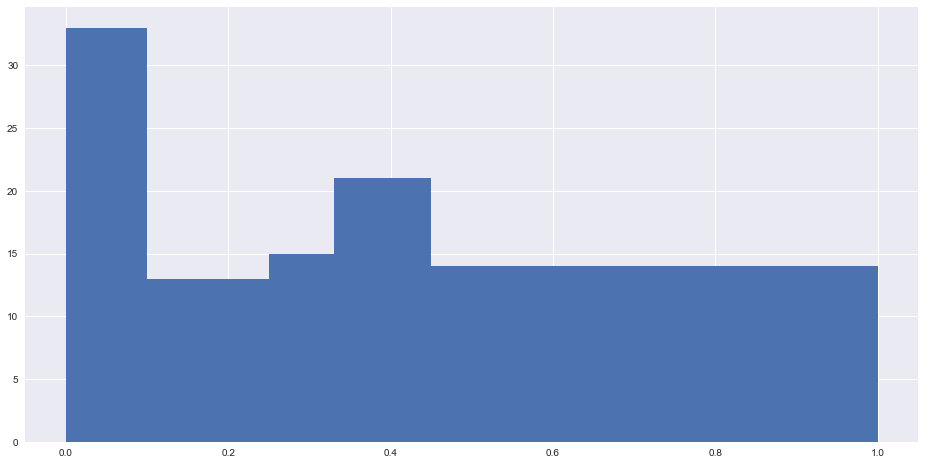

In [49]:
plt.figure(figsize=(16,8))
plt.hist(n_counts.inv_ratio, 
         # bins=[0, 0.1, 0.2, 0.3, 0.4, 0.6, 1.0],
         # bins=[0, 0.15, 0.45, 0.75, 1.0]
         bins=[0, 0.1, 0.25, 0.33, 0.45, 0.75, 1.0]
        );

In [53]:
def bin_neighborhoods(df, binlist=[0, 0.1, 0.25, 0.33, 0.45, 0.75, 1.0]):
    """
    Assigns each neighborhood a bin number based on ratio of investors.
    ---
    IN
    df: neighborhoods dataframe with investor ratios (df)
    binlist: lower bounds for each bin
    OUT
    df: neighborhoods dataframe with investor ratio bins column
    """
    
    df['n_bin'] = 0
    
    for n, val in enumerate(binlist):
        df.n_bin[df.inv_ratio > val] = n
        
    return df

In [54]:
n_counts = bin_neighborhoods(n_counts)

/Users/dluther/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [67]:
n_counts[n_counts.inv_ratio > 0.75]

,neighborhood,n_count,inv_ratio,n_bin
74,Joy-Schaefer,2,1.0,5
88,Hubbard Farms,1,1.0,5
89,South of Six,1,1.0,5
94,Grandmont #1,1,1.0,5
99,Blackstone Park,1,1.0,5
100,Eden Gardens,1,1.0,5
101,Brightmoor,1,1.0,5
103,Riverdale,1,1.0,5
104,North Corktown,1,1.0,5
106,Sherwood,1,1.0,5


(array([ 33.,  17.,  11.,  21.,  17.,  11.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 6 Patch objects>)

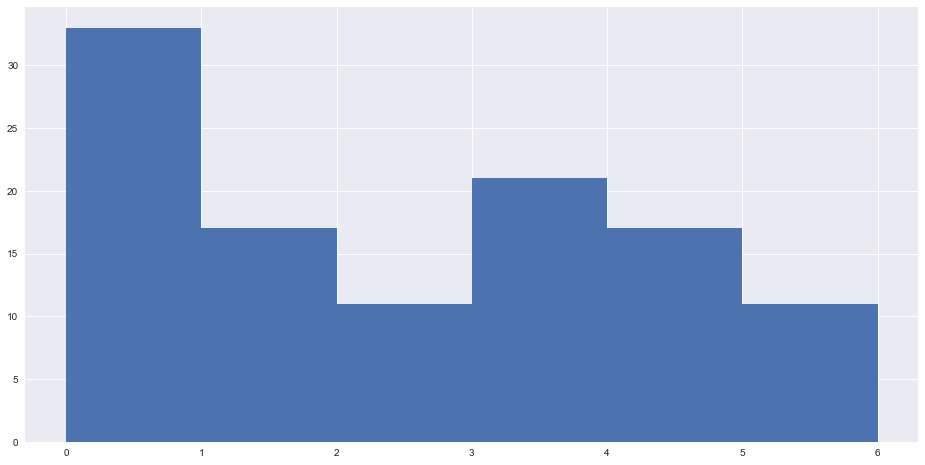

In [57]:
plt.figure(figsize=(16,8))
plt.hist(n_counts.n_bin, bins=6, range=[0,6])

In [69]:
auctions = pd.merge(auctions, n_counts.filter(['neighborhood', 'n_bin']), how='left', on='neighborhood')

### Counting Other Auction Properties Within Radius

In [71]:
for n, thresh in enumerate([0.1,0.2,0.5]):
    auctions['thr_' + str(n)] = auctions.apply(lambda row: mcnultymod.proximity_val(row, 
                                                                                   auctions, 
                                                                                   thresh
                                                                                  ), axis=1)

KeyboardInterrupt: 

In [ ]:
auctions.thr_0.value_counts()

In [ ]:
auctions.thr_1.value_counts()

In [ ]:
auctions.thr_2.value_counts()

In [ ]:
for n, thresh in enumerate([0.1,0.2,0.5]):
    auctions['tcount_' + str(n)] = (auctions
     .apply(lambda row: mcnultymod.proximity_val(row, auctions, thresh, mode='cumulative'), axis=1)
                                   )

In [73]:
for n, thresh in enumerate([0.1,0.2,0.5]):
    auctions['ip_' + str(n)] = auctions.apply(lambda row: mcnultymod.proximity_val(row, 
                                                                                   auctions[auctions.purchasertype == 'Investor'], 
                                                                                   thresh,
                                                                                   mode='cumulative'
                                                                                  ), axis=1)

In [74]:
auctions[auctions.purchasertype == 'Investor'].head()

,address,parcelid,price,closingdate,salestatus,buyerstatus,purchasertype,program,councildistrict,neighborhood,latitude,longitude,location,num_permits,year,ptype_num,n_bin,ip_0,ip_1,ip_2
1,14345 Grandville,22088763.,11400.0,2015-04-23,Closed,Selected,Investor,Auction,1,Westwood Park,42.391877,-83.231375,"location\n(42.391877, -83.231375)",0.0,2015,1,4,1,1,4
3,2224 W Boston Blvd,10002831.,62800.0,2015-06-17,Closed,Selected,Investor,Auction,5,Boston Edison,42.380017,-83.106803,"location\n(42.380017, -83.106803)",0.0,2015,1,4,0,0,11
6,6859 Auburn,22092985.,1000.0,2017-03-08,Closed,Selected,Investor,Auction,7,Warrendale,42.341779,-83.233166,"location\n(42.341779, -83.233166)",0.0,2017,1,2,3,5,12
11,8614 Northlawn,18014620.,1000.0,2017-02-09,Closed,Selected,Investor,Auction,7,Barton-McFarland,42.358337,-83.151738,"location\n(42.358337, -83.151738)",0.0,2017,1,3,0,0,5
12,7347 Heyden,22099990.,9600.0,2017-09-28,Closed,Selected,Investor,Auction,7,Warrendale,42.345250,-83.238269,"location\n(42.34525, -83.238269)",0.0,2017,1,2,2,2,10


### Binning Price

In [75]:
auctions['p_bin'] = 0
auctions.p_bin[auctions.price > 5000] = 1
auctions.p_bin[auctions.price > 20000] = 2

/Users/dluther/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/dluther/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### Examining Correlations

In [76]:
auctions.filter(['ptype_num', 
                 'price',
                 'p_bin',
#                 'num_permits', 
#                 'year', 
                 'councildistrict', 
                 'n_bin',
                 'thr_0',
                 'thr_1',
                 'thr_2',
                 'tcount_0',
                 'tcount_1',
                 'tcount_2',
                 'ip_0',
                 'ip_1',
                 'ip_2'
                ]).corr()

,ptype_num,price,p_bin,councildistrict,n_bin,ip_0,ip_1,ip_2
ptype_num,1.000000,0.029036,0.053263,0.013897,0.326055,0.052812,-0.010864,-0.006687
price,0.029036,1.000000,0.774980,0.018727,0.162510,0.062960,0.123583,0.166499
p_bin,0.053263,0.774980,1.000000,-0.017947,0.127289,0.039214,0.117351,0.136699
councildistrict,0.013897,0.018727,-0.017947,1.000000,0.061427,0.144480,0.230479,0.321733
n_bin,0.326055,0.162510,0.127289,0.061427,1.000000,0.178748,0.226238,0.222340
ip_0,0.052812,0.062960,0.039214,0.144480,0.178748,1.000000,0.681933,0.437329
ip_1,-0.010864,0.123583,0.117351,0.230479,0.226238,0.681933,1.000000,0.662742
ip_2,-0.006687,0.166499,0.136699,0.321733,0.222340,0.437329,0.662742,1.000000


Finally, some noticeable correlation between neighborhood bin and purchaser type, though it is disappointing that any other correlations are virtually nonexistent...

In [ ]:
auctions.to_pickle('../data/auctionsclosed_v2.pkl')